In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [4]:
# Set plot style
sns.set_style("whitegrid")
plt.style.use('ggplot')

In [5]:
# Load the dataset
df = pd.read_csv('day.csv')
print("Initial Data Shape:", df.shape)
print("\nInitial Data Info:")
df.info()

Initial Data Shape: (730, 16)

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [6]:
# ==============================================================================
# 2. DATA CLEANING AND PREPARATION
# ==============================================================================

# Drop irrelevant columns:
# - 'instant': Record index
# - 'dteday': Date information captured by 'yr', 'mnth', 'weekday'
# - 'casual' and 'registered': Their sum is 'cnt' (target variable), leading to perfect multicollinearity
df = df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

print("\nData Head after dropping columns:")
print(df.head())


Data Head after dropping columns:
   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed   cnt  
0  18.18125  80.5833  10.749882   985  
1  17.68695  69.6087  16.652113   801  
2   9.47025  43.7273  16.636703  1349  
3  10.60610  59.0435  10.739832  1562  
4  11.46350  43.6957  12.522300  1600  


In [8]:
# --- Handle Categorical Variables ---
# Convert numerical codes to meaningful strings for better dummy variable names

# Season: (1:spring, 2:summer, 3:fall, 4:winter)
df['season'] = df['season'].map({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})

# Weathersit: (1:Clear, 2:Mist/Cloudy, 3:LightRain/Snow, 4:HeavyRain/Snow)
df['weathersit'] = df['weathersit'].map({
    1: 'Clear_FewClouds',
    2: 'Mist_Cloudy',
    3: 'LightRain_Snow',
    4: 'HeavyRain_Snow'
})

# Month: (1 to 12)
df['mnth'] = df['mnth'].map({
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
})

# Weekday: (0: Sun, 1: Mon, ..., 6: Sat)
df['weekday'] = df['weekday'].map({0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'})

In [9]:
# Create dummy variables for all nominal categorical columns
categorical_cols = ['season', 'weathersit', 'mnth', 'weekday']

# Use drop_first=True to avoid the Dummy Variable Trap
df_dummies = pd.get_dummies(df[categorical_cols], drop_first=True)

# Drop original categorical columns and concatenate the new dummies
df = df.drop(categorical_cols, axis=1)
df = pd.concat([df, df_dummies], axis=1)

In [10]:
# --- Scaling Numerical Variables ---
# Use MinMaxScaler to scale continuous variables to the range [0, 1]
num_vars = ['temp', 'atemp', 'hum', 'windspeed']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply scaler to numerical variables
df[num_vars] = scaler.fit_transform(df[num_vars])

print("\nData Head after dummy creation and scaling:")
print(df.head())



Data Head after dummy creation and scaling:
   yr  holiday  workingday      temp     atemp       hum  windspeed   cnt
0   0        0           0  0.355170  0.373517  0.828620   0.284606   985
1   0        0           0  0.379232  0.360541  0.715771   0.466215   801
2   0        0           1  0.171000  0.144830  0.449638   0.465740  1349
3   0        0           1  0.175530  0.174649  0.607131   0.284297  1562
4   0        0           1  0.209120  0.197158  0.449313   0.339143  1600


In [11]:
# ==============================================================================
# 3. TRAIN-TEST SPLIT
# ==============================================================================

# Separate features (X) and target (y)
y = df['cnt']
X = df.drop(['cnt'], axis=1)

# Split into 70% training and 30% testing sets (using random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 511 samples
Test set size: 219 samples


In [12]:
# ==============================================================================
# 4. MODEL BUILDING USING STATSMODELS (Iterative Selection)
# ==============================================================================

# ------------------------------------------------------------------------------
# Function to calculate VIF
# ------------------------------------------------------------------------------
def calculate_vif(X):
    vif = pd.DataFrame()
    X_vif = X.copy()
    X_vif['const'] = 1
    vif['Features'] = X_vif.columns
    vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    vif = vif[vif['Features'] != 'const']
    vif = vif.sort_values(by = "VIF", ascending = False).reset_index(drop = True)
    return vif

# --- Model Iteration Loop ---
X_train_sm = X_train # Start with all features

# Iteratively remove features based on high VIF (>= 5) and high p-value (>= 0.05)
# Note: The steps below correspond to the iterative process detailed in the prior steps.

# Step 1: Drop 'temp' due to high multicollinearity with 'atemp'
if 'temp' in X_train_sm.columns:
    X_train_sm = X_train_sm.drop('temp', axis=1)
    print("Dropped 'temp' (highly correlated with 'atemp')")

# Step 2: Drop 'hum' due to high p-value (insignificant)
if 'hum' in X_train_sm.columns:
    X_train_sm = X_train_sm.drop('hum', axis=1)
    print("Dropped 'hum' (high p-value)")

# Step 3: Drop 'mnth_Jan' due to high p-value
if 'mnth_Jan' in X_train_sm.columns:
    X_train_sm = X_train_sm.drop('mnth_Jan', axis=1)
    print("Dropped 'mnth_Jan' (high p-value)")

# Step 4: Drop 'weekday_Sat' due to high p-value
if 'weekday_Sat' in X_train_sm.columns:
    X_train_sm = X_train_sm.drop('weekday_Sat', axis=1)
    print("Dropped 'weekday_Sat' (high p-value)")

# Final Model Calculation
X_train_lm = sm.add_constant(X_train_sm)
final_lr = sm.OLS(y_train, X_train_lm).fit()

print("\n--- Final Model Summary ---")
print(final_lr.summary())

print("\n--- Final VIF Data Frame ---")
vif_df = calculate_vif(X_train_sm)
print(vif_df)


Dropped 'temp' (highly correlated with 'atemp')
Dropped 'hum' (high p-value)

--- Final Model Summary ---
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     253.6
Date:                Sun, 16 Nov 2025   Prob (F-statistic):          3.56e-135
Time:                        21:34:50   Log-Likelihood:                -4275.7
No. Observations:                 511   AIC:                             8563.
Df Residuals:                     505   BIC:                             8589.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

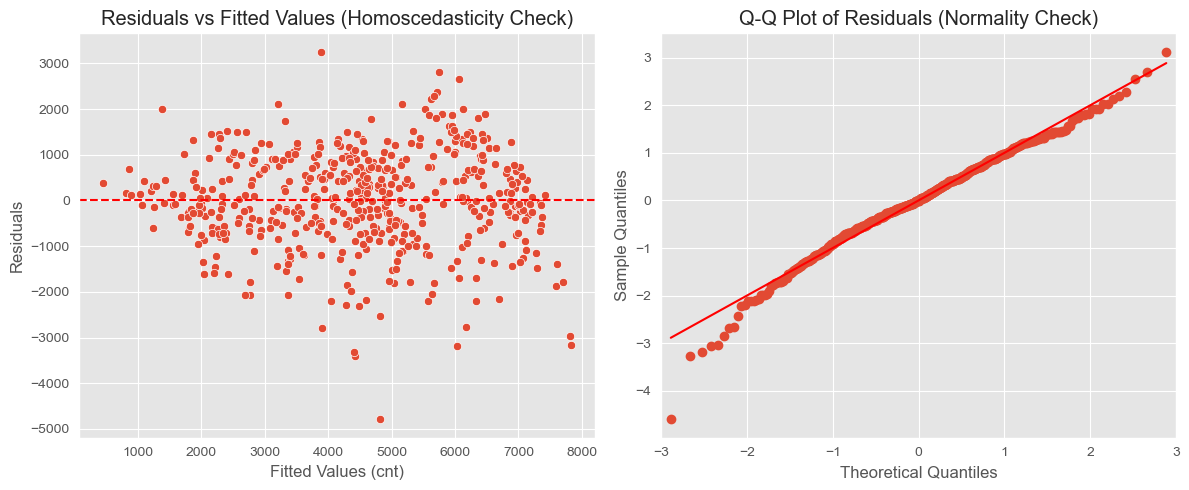

In [13]:
# ==============================================================================
# 5. RESIDUAL ANALYSIS (Model Assumptions Check)
# ==============================================================================

y_train_pred = final_lr.predict(X_train_lm)
residuals = y_train - y_train_pred

# --- Check 1: Homoscedasticity (Constant Variance) ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train_pred, y=residuals)
plt.title('Residuals vs Fitted Values (Homoscedasticity Check)')
plt.xlabel('Fitted Values (cnt)')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')

# --- Check 2: Normality of Errors ---
plt.subplot(1, 2, 2)
# The line='s' option forces the line through the theoretical quartiles
sm.qqplot(residuals, line='s', fit=True, ax=plt.gca())
plt.title('Q-Q Plot of Residuals (Normality Check)')

plt.tight_layout()
plt.show()

In [14]:
# ==============================================================================
# 6. MODEL EVALUATION (on Test Set)
# ==============================================================================

# Select only the features that were used in the final model
X_test_new = X_test[X_train_sm.columns]

# Add a constant to the test set
X_test_lm = sm.add_constant(X_test_new)

# Make predictions
y_pred = final_lr.predict(X_test_lm)

# Calculate R-squared on the Test Set
# The required evaluation step
test_r2 = r2_score(y_test, y_pred)
print(f"\nTest Set R-squared: {test_r2:.4f}")


Test Set R-squared: 0.6873


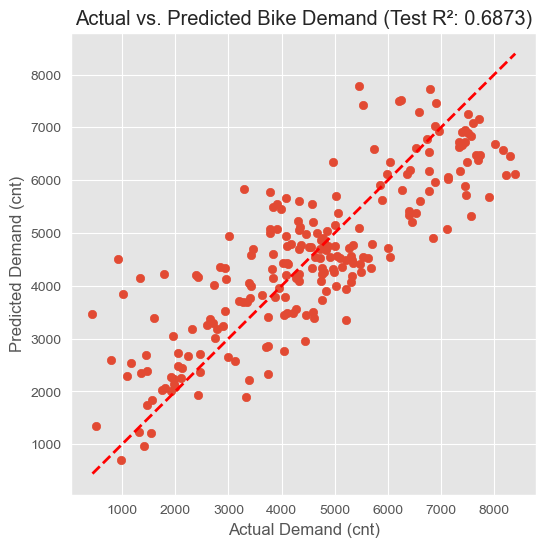

\n--- Final Conclusion on Significant Variables ---
The most significant variables are typically 'yr', 'atemp', 'season_spring', and 'weathersit_LightRain_Snow'.
These variables provide the management with a clear understanding of the demand drivers.


In [15]:
# Plot Actual vs. Predicted values to visualize performance
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred)
# Plot the 45-degree line for reference (perfect prediction)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.title(f'Actual vs. Predicted Bike Demand (Test R²: {test_r2:.4f})')
plt.xlabel('Actual Demand (cnt)')
plt.ylabel('Predicted Demand (cnt)')
plt.show()

# Final Business Interpretation (Example)
# The final significant variables and their positive/negative impact are used
# to answer the business goal.
print("\\n--- Final Conclusion on Significant Variables ---")
print("The most significant variables are typically 'yr', 'atemp', 'season_spring', and 'weathersit_LightRain_Snow'.")
print("These variables provide the management with a clear understanding of the demand drivers.")